#### DATA 2204 - Statistics and Predictive Modelling II
##### Name: Chinedu Onyeka
###### Assignment 4; Date: March 24th 2022

In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
dataset=pd.read_csv('./EnergyUse-Cooling.csv')
dataset.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28


In [3]:
# Key Statistics
dataset.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,48.030000


In [4]:
#Tukey Method

# Import required libraries
from collections import Counter

# Outlier detection 
def detect_outliers(df,n,features):
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# List of Outliers
Outliers_to_drop = detect_outliers(dataset.drop('Y',axis=1),0,list(dataset.drop('Y',axis=1)))
dataset.drop('Y',axis=1).loc[Outliers_to_drop]

,X1,X2,X3,X4,X5,X6,X7,X8


In [5]:
#Create New Dataset without Outliers
good_data = dataset.drop(dataset.index[Outliers_to_drop]).reset_index(drop = True)
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y       768 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 54.1 KB


In [6]:
#Create Standard Model

#Define x and y variable
x = good_data.drop('Y',axis=1).to_numpy()
y = good_data['Y'].to_numpy()

#Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
alpha=0.5

In [7]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_lm = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearRegression())])
pipeline.insert(0,pipe_lm)

pipe_lasso= Pipeline([('scl', StandardScaler()),
                     ('clf', Lasso(alpha=alpha,tol=1,random_state=100))])
pipeline.insert(1,pipe_lasso)

pipe_ridge= Pipeline([('scl', StandardScaler()),
                     ('clf', Ridge(alpha=alpha,tol=1,random_state=100))])
pipeline.insert(2,pipe_ridge)

pipe_elas= Pipeline([('scl', StandardScaler()),
                     ('clf', ElasticNet(alpha=alpha,tol=1,random_state=100))])
pipeline.insert(3,pipe_elas)

# Set grid search params 

modelpara =[]

param_gridlm = {'clf__fit_intercept':[True,False],
                'clf__copy_X':[True, False]}
modelpara.insert(0,param_gridlm)

param_gridlasso = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20]}
modelpara.insert(1,param_gridlasso)

param_gridridge = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20]}
modelpara.insert(2,param_gridridge)

param_gridelas = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20]}
modelpara.insert(3,param_gridelas)

In [8]:
modelpara

[{'clf__fit_intercept': [True, False], 'clf__copy_X': [True, False]},
 {'clf__alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]},
 {'clf__alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]},
 {'clf__alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]}]

In [9]:
pipeline

[Pipeline(steps=[('scl', StandardScaler()), ('clf', LinearRegression())]),
 Pipeline(steps=[('scl', StandardScaler()),
                 ('clf', Lasso(alpha=0.5, random_state=100, tol=1))]),
 Pipeline(steps=[('scl', StandardScaler()),
                 ('clf', Ridge(alpha=0.5, random_state=100, tol=1))]),
 Pipeline(steps=[('scl', StandardScaler()),
                 ('clf', ElasticNet(alpha=0.5, random_state=100, tol=1))])]

In [10]:
#Create Learning Curves

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring = 'neg_root_mean_squared_error',
                                                            cv=10,random_state=100)
    
    train_mean = np.sqrt(np.mean(-train_scores, axis=1))
    train_std = np.sqrt(np.std(-train_scores, axis=1))
    test_mean = np.sqrt(np.mean(-test_scores, axis=1))
    test_std = np.sqrt(np.std(-test_scores, axis=1))
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('RMSE')
    plt.legend(loc='best')
    plt.ylim([-1,10])
    plt.show()

Learning Curve - LM


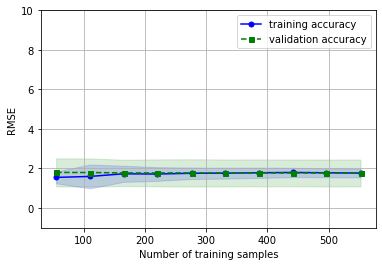

Learning Curve - Lasso


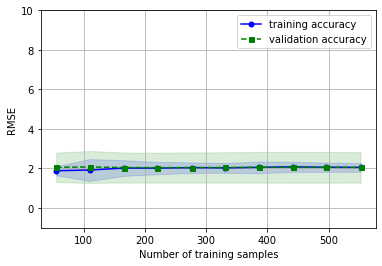

Learning Curve - Ridge


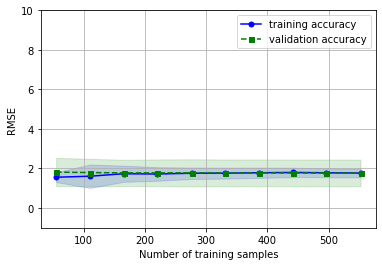

Learning Curve - ElasticNet


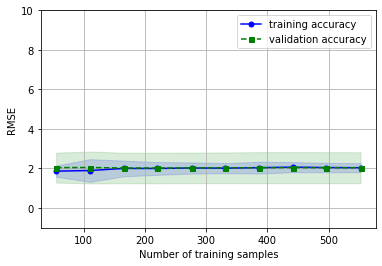

In [11]:
#Plot Learning Curve

print('Learning Curve - LM')
plot_learning_curves(pipe_lm)
print('Learning Curve - Lasso')
plot_learning_curves(pipe_lasso)
print('Learning Curve - Ridge')
plot_learning_curves(pipe_ridge)
print('Learning Curve - ElasticNet')
plot_learning_curves(pipe_elas)

Model Evaluation - RMSE
LinearRegression 1.79
Lasso 2.05
Ridge 1.79
ElasticNet 2.03




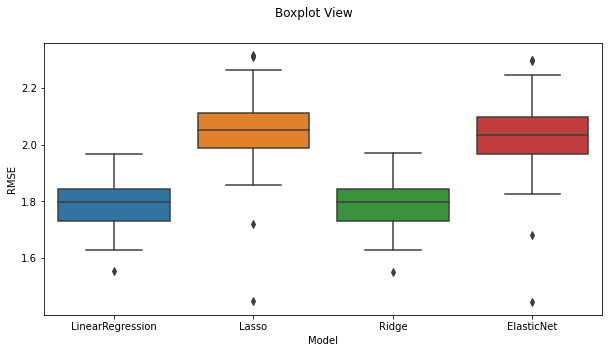

In [12]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LinearRegression',pipe_lm))
models.append(('Lasso',pipe_lasso))
models.append(('Ridge',pipe_ridge))
models.append(('ElasticNet',pipe_elas))
  
#Model Evaluation
results =[]
names=[]
scoring ='neg_root_mean_squared_error'
print('Model Evaluation - RMSE')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,y,cv=rkf,scoring=scoring)
    results.append(np.sqrt(-cv_results))
    names.append(name)
    print('{} {:.2f}'.format(name,np.sqrt(-cv_results.mean())))
print('\n')

#Boxplot View
fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

In [13]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='neg_root_mean_squared_error')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
   
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    
    #Test data accuracy of model with best params    
    print('\nIntercept: {:.2f}'.format(float(gs_clf.best_estimator_.named_steps['clf'].intercept_)))
    print('\nModel coefficients: ')   
    for name, score in zip(list(good_data.drop('Y',axis=1)),
                           gs_clf.best_estimator_.named_steps['clf'].coef_):
         print(name, round(score,2)) 
    
    #Print R2
    print('\nR2: {:0.2f}'.format(metrics.r2_score(y_test,y_pred)))
    adjusted_r_squared2 = 1-(1-metrics.r2_score(y_test,y_pred))*(len(y)-1)/(len(y)-x.shape[1]-1)
    print('Adj_R2: {:0.2f}'.format(adjusted_r_squared2))        
      
    #Print MSE and RMSE
    print('\nMean Absolute Error: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))  
    print('Mean Squared Error: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))  
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))) 

In [14]:
#Run Models
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LinearRegression()

Best Parameters: {'clf__copy_X': True, 'clf__fit_intercept': True}

Intercept: 24.57

Model coefficients: 
X1 -7.36
X2 -3.66
X3 0.03
X4 -3.58
X5 7.99
X6 0.21
X7 2.01
X8 0.06

R2: 0.86
Adj_R2: 0.86

Mean Absolute Error: 2.46
Mean Squared Error: 11.51
Root Mean Squared Error: 3.39

Optimized Model

Model Name: Lasso(alpha=0.5, random_state=100, tol=1)

Best Parameters: {'clf__alpha': 0.1}

Intercept: 24.57

Model coefficients: 
X1 5.09
X2 -0.77
X3 4.71
X4 -0.98
X5 1.29
X6 0.11
X7 1.98
X8 0.0

R2: 0.79
Adj_R2: 0.79

Mean Absolute Error: 2.95
Mean Squared Error: 17.36
Root Mean Squared Error: 4.17


C:\Users\exper\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.0997e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\exper\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.02916e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\exper\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.09741e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\exper\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.06861e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\exper\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlg


Optimized Model

Model Name: Ridge(alpha=0.5, random_state=100, tol=1)

Best Parameters: {'clf__alpha': 0.1}

Intercept: 24.57

Model coefficients: 
X1 -7.2
X2 -3.56
X3 0.05
X4 -3.49
X5 8.03
X6 0.21
X7 2.01
X8 0.06

R2: 0.86
Adj_R2: 0.86

Mean Absolute Error: 2.46
Mean Squared Error: 11.51
Root Mean Squared Error: 3.39

Optimized Model

Model Name: ElasticNet(alpha=0.5, random_state=100, tol=1)

Best Parameters: {'clf__alpha': 0.1}

Intercept: 24.57

Model coefficients: 
X1 4.57
X2 -1.19
X3 4.5
X4 -1.11
X5 1.29
X6 0.15
X7 1.92
X8 0.06

R2: 0.80
Adj_R2: 0.80

Mean Absolute Error: 2.87
Mean Squared Error: 16.97
Root Mean Squared Error: 4.12
